In [1]:
from PIL import Image
import numpy as np
import random
import os
from keras.callbacks import LearningRateScheduler
import keras.backend as K
from keras.utils import plot_model
from keras.applications.vgg16 import VGG16
from keras.layers import Dense,Flatten,MaxPooling2D,Dropout
from keras.models import Model,load_model
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import xml.etree.ElementTree as ET
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline

/home/chenxin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#初始化
imsize = 224
img_dir = 'trainval/img/'
imgs = os.listdir(img_dir)
num_total = len(imgs)
X = np.zeros((num_total,imsize,imsize,3))
Y = np.zeros((num_total,4))
HW = np.zeros((num_total,2))

In [3]:
#预处理
for i in range(num_total):
    img = Image.open('trainval/img/'+imgs[i])
    h,w,_ = np.array(img).shape
    HW[i] = np.array([h,w])
    img = img.resize((imsize,imsize))
    img = np.array(img)
    X[i] = img/255
    img_name = imgs[i][:-4]
    ann_name = img_name+'.xml'
    ann = ET.parse('trainval/box/'+ann_name)
    box = [int(ann.find(tag).text)-1
               for tag in ['xmin', 'ymin', 'xmax', 'ymax']]
    xmin,ymin,xmax,ymax = box
    # 对标签归一化(转化为与原始图像的H、W的一个比例)
    xmin_n,xmax_n = [xmin/w,xmax/w]
    ymin_n,ymax_n = [ymin/h,ymax/h]
    # 对标签去归一化（对上边得到的比例乘以imsize)
    x_c = (xmin_n+xmax_n)/2 *imsize
    y_c = (ymin_n+ymax_n)/2 *imsize
    bbox_w = (xmax_n - xmin_n)*imsize
    bbox_h = (ymax_n - ymin_n)*imsize
    Y[i] = [x_c, y_c, bbox_w, bbox_h]

In [4]:
#保存处理好的标签与数据
np.save("X.npy",X)
np.save("Y.npy",Y)

In [3]:
X = np.load('X.npy')
Y = np.load('Y.npy')

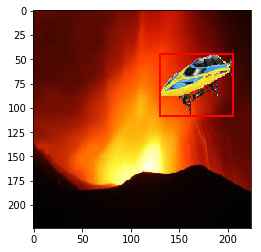

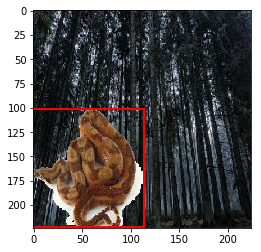

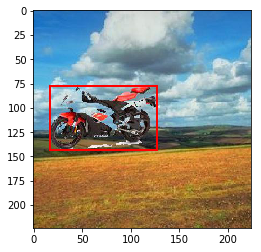

In [4]:
#画图检查保存的是否正确
for i in range(3):
    img = X[i]
    img = img
    box = Y[i]
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    rect = patches.Rectangle(
        (box[0]-box[2]/2, box[1]-box[3]/2), box[2], box[3], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

In [6]:
random.seed(10)
permutation = np.random.permutation(Y.shape[0])
X = X[permutation, :]
Y = Y[permutation]
#划分测试集与验证集，keras训练时可以自动划分，但是在这里感觉不灵活，还是选择了手动划分,最后一次训练时不再划分验证集
# X_val = X[:200]
# Y_val = Y[:200]
X_train = X
Y_train = Y

In [5]:
HUBER_DELTA = 0.5
def smoothL1(y_true, y_pred):
    x   = K.abs(y_true - y_pred)
    x   = K.switch(x < HUBER_DELTA, 0.5 * x ** 2, HUBER_DELTA * (x - 0.5 * HUBER_DELTA))
    return  K.sum(x)

In [6]:
import keras.losses
keras.losses.smoothL1 = smoothL1

In [9]:
#keras自带的VGG16模型,去掉最后的三个全连接层,换成我自己添加的全连接层
def mymodel(nb_classes=4, img_rows=imsize, img_cols=imsize, RGB=True):
        color = 3 if RGB else 1
        base_model = VGG16(weights='imagenet', include_top=True, pooling=None, input_shape=(img_rows, img_cols, color),
                              )

        #也训练前边的参数
        for layer in base_model.layers:
            layer.trainable = True
            
        x = base_model.get_layer('fc2').output
        x = Dropout(0.5)(x)
        predictions = Dense(nb_classes, activation='linear')(x)
        #训练模型
        model = Model(inputs=base_model.input, outputs=predictions)
        #lr一开始用0.001，后来换成0.005快了很多，而如果在第2题中也换成0.005，就不合适了
        adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        model.compile(loss=smoothL1, optimizer=adam)
        return model


In [10]:
#一开始不知道倒数第二个全连接层叫什么名字，这里可以显示一下每一层的属性
# model = VGG16(weights='imagenet', include_top=True, pooling=None, input_shape=(imsize, imsize, 3))
# print(model.summary())

In [11]:
#降学习率的函数，每10个epoch降一次
def scheduler(epoch):
    if epoch % 10 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.1)
        print("lr changed to {}".format(lr * 0.1))
    return K.get_value(model.optimizer.lr)
reduce_lr = LearningRateScheduler(scheduler)
model = mymodel()
model.fit(X_train, Y_train, batch_size=16, epochs=20,callbacks=[reduce_lr])

Epoch 1/20
2000/2000 [==============================] - 48s 24ms/step - loss: 811.3294
Epoch 2/20
2000/2000 [==============================] - 36s 18ms/step - loss: 501.2644
Epoch 3/20
2000/2000 [==============================] - 36s 18ms/step - loss: 423.2591
Epoch 4/20
2000/2000 [==============================] - 36s 18ms/step - loss: 364.3321
Epoch 5/20
2000/2000 [==============================] - 37s 18ms/step - loss: 322.4935
Epoch 6/20
2000/2000 [==============================] - 36s 18ms/step - loss: 293.8426
Epoch 7/20
2000/2000 [==============================] - 37s 18ms/step - loss: 280.0887
Epoch 8/20
2000/2000 [==============================] - 37s 18ms/step - loss: 252.5643
Epoch 9/20
2000/2000 [==============================] - 37s 18ms/step - loss: 235.6638
Epoch 10/20
2000/2000 [==============================] - 37s 18ms/step - loss: 233.7790
Epoch 11/20
lr changed to 9.999999747378752e-06
2000/2000 [==============================] - 37s 18ms/step - loss: 186.5899
Epoch

In [12]:
#存模型
model.save('mymodel') 

In [13]:
# #画几个图看看预测效果
# start = 20
# for id in range(start,start+10):
#     box = model.predict(X_val[id:id+1])
#     box = box.squeeze()
#     fig, ax = plt.subplots(1)
#     ax.imshow(X_val[id])
#     rect = patches.Rectangle(
#             (box[0]-box[2]/2, box[1]-box[3]/2), box[2], box[3], linewidth=2, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)

In [14]:
#计算iou
def iou(bbox,gt):
    iou = 0
    # 传入的Bbox和gt都是原图的尺寸（resize前的）
    x,y,w,h = bbox
    x_gt,y_gt,w_gt,h_gt = gt
    # 将中心点、长、宽转化为左上角坐标和右下角坐标
    x1,y1,x2,y2 = [x-w/2,y-h/2,x+w/2,y+h/2]
    x1_gt,y1_gt,x2_gt,y2_gt = [x_gt-w_gt/2,y_gt-h_gt/2,x_gt+w_gt/2,y_gt+h_gt/2]
    xi1 = max(x1,x1_gt)
    yi1 = max(y1,y1_gt)
    xi2 = min(x2,x2_gt)
    yi2 = min(y2,y2_gt)
    area_i = max(0,(xi2-xi1))*max(0,(yi2-yi1))
    area1 = w*h
    area2 = w_gt*h_gt
    area_u = area1+area2-area_i
    iou = area_i/area_u
    return iou

In [18]:
# #看一下准确度

# threshold = 0.5
# count = 0
# num_val = 200
# for i in range(num_val):
#     bbox = model.predict(X_val[i:i+1])
#     bbox = bbox.squeeze()
#     GT = Y_val[i]
#     tmp = iou(bbox,GT)
#     if tmp>threshold:
#         count=count+1
# print("准确度为：",count/num_val)

准确度为： 0.945


In [10]:
#测试集预处理
img_dir = 'test/img/'
imgs = os.listdir(img_dir)
X_test = np.zeros((len(imgs),imsize,imsize,3))
HW_test = np.zeros((len(imgs),2))

In [11]:
for i in range(len(imgs)):
    img = Image.open('test/img/'+imgs[i])
    h,w,_ = np.array(img).shape
    HW_test[i] = np.array([h,w])
    img = img.resize((imsize,imsize))
    img = np.array(img)
    X_test[i] = img/255

In [17]:
np.save("X_test.npy",X_test)

In [3]:
X_test = np.load('X_test.npy')

In [12]:
from keras.models import load_model
model = load_model('mymodel')  

In [13]:
from xml.dom.minidom import Document

In [14]:
for i in range(len(imgs)):
    bbox = model.predict(X_test[i:i+1])
    bbox = bbox.squeeze()
    x,y,w,h = bbox
    x_min,y_min,x_max,y_max = [x-w/2,y-h/2,x+w/2,y+h/2]
    x_min = x_min/imsize*HW_test[i,1]
    x_max = x_max/imsize*HW_test[i,1]
    y_min = y_min/imsize*HW_test[i,0]
    y_max = y_max/imsize*HW_test[i,0]
    img_name = imgs[i][:-4]
    box = [x_min,y_min,x_max,y_max]
    conf = 1
    # 保存结果
    result = ET.Element("prediction")
    ann_box = ET.SubElement(result,"bndbox")
    ET.SubElement(ann_box, "xmin").text = str(int(box[0]))
    ET.SubElement(ann_box, "ymin").text = str(int(box[1]))
    ET.SubElement(ann_box, "xmax").text = str(int(box[2]))
    ET.SubElement(ann_box, "ymax").text = str(int(box[3]))
    ET.SubElement(ann_box, "conf").text = '%.4f'%conf
    tree = ET.ElementTree(result)
    tree.write('test/box/'+str(img_name)+'.xml')

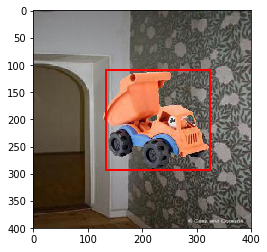

In [25]:
#看看效果
img = Image.open('test/img/00000285_176.jpg')
img = np.array(img)
ann = ET.parse('test/box/00000285_176.xml')
ann = ann.find('bndbox')
box = [int(ann.find(tag).text)-1
           for tag in ['xmin', 'ymin', 'xmax', 'ymax',]]
fig, ax = plt.subplots(1)
ax.imshow(img)
rect = patches.Rectangle(
    (box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)